# MSCA ML Final Project: Face-to-BMI
# Part 2: Image Embedding and Basic VGG

Deliverables:

1-You must create a simple web API to predict a user's BMI in real-time. You can also use webcam input. The goal is to use one of the pre-trained image models (e.g. VGG Face), fine-tune with the provided data, and deploy via jupyter notebook, streamlit, flask or any other simple restful api's.

2-10 pages of the write-up about your implementation.

3-10 mins presentation or live demo in the final lecture.

Our goal is to beat the performance metrics provided in the paper.

## Set-up

### Prepare basics

In [1]:
# # colab mount
# import os
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive/')
# path_gdrive = '/content/drive/MyDrive/Colab Datasets/ML/BMI'
# os.chdir(path_gdrive)
# print(os.getcwd())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Datasets/ML/BMI


In [2]:
# from pathlib import Path
# # create metrics, model dirs
# Path('./metrics').mkdir(parents = True, exist_ok = True)
# Path('./saved_model').mkdir(parents = True, exist_ok = True)

In [1]:
import os

# Google Bucket
bucket_path = 'gs://msca-sp23-bucket/ml_data'
file = 'BMI-20230313T174553Z-001.zip'
runtime_path = '/home/jupyter/data/ml/BMI'

os.chdir(runtime_path)
print(os.getcwd())

/home/jupyter/data/ml/BMI


In [2]:
import sys
import os
import pandas as pd
import numpy as np

import re
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [5]:
# read csv file
bmi = pd.read_csv(runtime_path + '/all_data.csv')
#bmi = pd.read_csv(path_gdrive + '/all_data.csv')
bmi.head(2)

,bmi,gender,is_training,name,imgae_type,id,path
0,34.207396,Male,1,img_0.bmp,bmp,0,/home/jupyter/data/ml/BMI/Images/img_0.bmp
1,26.453720,Male,1,img_1.bmp,bmp,1,/home/jupyter/data/ml/BMI/Images/img_1.bmp


In [6]:
import tensorflow as tf
from tensorflow import keras

2023-05-21 19:37:40.359500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 19:37:59.317008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-05-21 19:37:59.361438: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_

In [7]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.11.0
Keras version: 2.11.0


In [9]:
#!pip install keras_vggface

### Prepare Keras

In [10]:
# !python --version

In [11]:
# import site

# site_packages_path = site.getsitepackages()[0]
# print(site_packages_path)

In [12]:
# # @https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
# ! pip install git+https://github.com/rcmalli/keras-vggface.git
# ! pip install keras_applications --no-deps

# # filename = "/opt/conda/envs/nlp/lib/python3.10/site-packages/keras_vggface/models.py" # for gcp
# filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py" # for colab
# text = open(filename).read()
# open(filename, "w+").write(text.replace('keras.engine.topology', 'keras.utils.layer_utils'))

# filename = "/usr/local/lib/python3.10/dist-packages/mtcnn/mtcnn.py" # for colab
# text = open(filename).read()
# open(filename, "w+").write(text.replace('out = self._pnet.predict(img_y)', 'out = self._pnet.predict(img_y, verbose=0)'))
# open(filename, "w+").write(text.replace('out = self._rnet.predict(img_y)', 'out = self._rnet.predict(tempimg1, verbose=0)'))
# open(filename, "w+").write(text.replace('out = self._onet.predict(img_y)', 'out = self._onet.predict(tempimg1, verbose=0)'))

# ! pip install opencv-python
# ! pip install mtcnn

## Descriptive Analysis
Many thanks and reference to [Chaoran Liu](https://6chaoran.wordpress.com/2020/01/17/detect-faces-and-predict-age-gender-bmi-using-keras/)

In [8]:
bmi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3963 entries, 0 to 3962
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bmi          3963 non-null   float64
 1   gender       3963 non-null   object 
 2   is_training  3963 non-null   int64  
 3   name         3963 non-null   object 
 4   imgae_type   3963 non-null   object 
 5   id           3963 non-null   int64  
 6   path         3963 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 216.9+ KB


In [10]:
bmi.head()

,bmi,gender,is_training,name,imgae_type,id,path
0,34.207396,Male,1,img_0.bmp,bmp,0,/home/jupyter/data/ml/BMI/Images/img_0.bmp
1,26.453720,Male,1,img_1.bmp,bmp,1,/home/jupyter/data/ml/BMI/Images/img_1.bmp
2,34.967561,Female,1,img_2.bmp,bmp,2,/home/jupyter/data/ml/BMI/Images/img_2.bmp
3,22.044766,Female,1,img_3.bmp,bmp,3,/home/jupyter/data/ml/BMI/Images/img_3.bmp
4,25.845588,Female,1,img_6.bmp,bmp,6,/home/jupyter/data/ml/BMI/Images/img_6.bmp


In [9]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12

Distribution

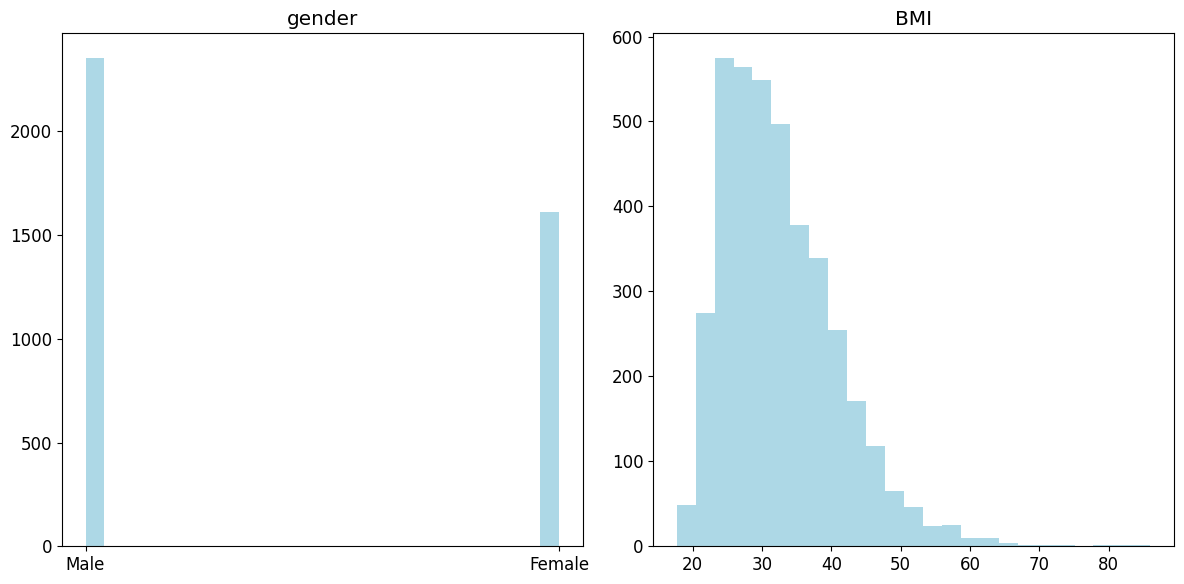

In [12]:
def ax_subplot(ax, x, title, bins = 25, color = 'lightblue'):
    x = x[~x.isnull()]
    ax.hist(x, bins = bins, color = color)
    ax.set_title(title)
    
fig, ax = plt.subplots(1,2)
ax_subplot(ax[0], bmi.gender, 'gender')
ax_subplot(ax[1], bmi.bmi, 'BMI')
plt.tight_layout()
plt.show()

BMI by gender group

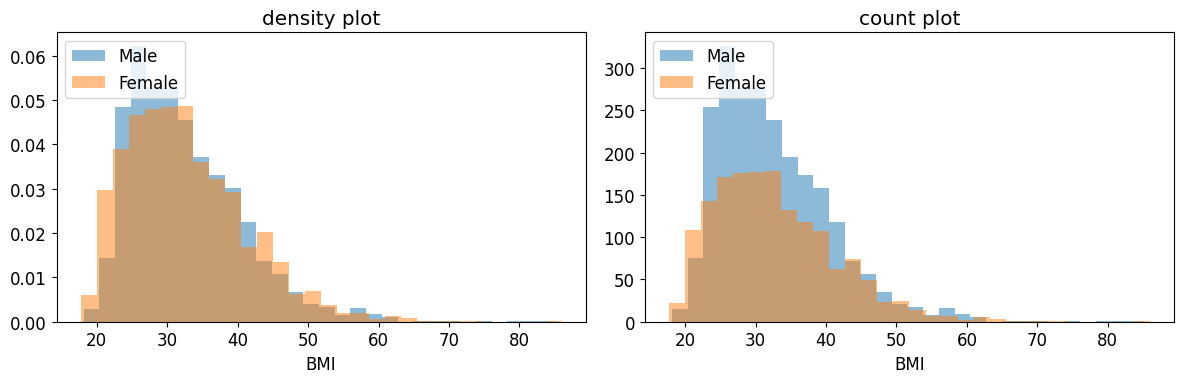

In [16]:
fig, ax = plt.subplots(1,2,sharex=True)
fig.set_size_inches(12,4)
options = {'density plot': True, 'count plot': False}

for i, (title, normed) in enumerate(options.items()):

    for sex in ['Male','Female']:
        ax[i].hist(bmi.loc[(bmi.gender == sex) & (~bmi.bmi.isnull()),'bmi'].values, label = sex, alpha = 0.5, 
                 bins = 30, density = normed)
        ax[i].set_title(title)
        ax[i].set_xlabel('BMI')
        ax[i].legend(loc = 'upper left')
        
plt.tight_layout()        
plt.show()

## Helper Functions

### General Functions

In [13]:
# keras vggface model
import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Activation, BatchNormalization

from keras_vggface.vggface import VGGFace
from keras.models import Model
# example of loading an image with the Keras API
# since 2021 tensorflow updated the package and moved model directory
from tensorflow.keras.preprocessing import image
import keras_vggface.utils as utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# image manipulation
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import cv2

# face alignment
from mtcnn.mtcnn import MTCNN

# model metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# common packages
import os
import numpy as np
import pandas as pd
import pickle

import shutil
from tqdm import tqdm
import tempfile
import hashlib

# Operations regarding to folder/file
def copy_images(file_paths, source_folder, destination_folder):
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        source_file = os.path.join(source_folder, file_name)
        destination_file = os.path.join(destination_folder, file_name)
        shutil.copyfile(source_file, destination_file)

def get_file_names(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

# Easy-to-use Performance metrics
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

def mae(x,y):
    return mean_absolute_error(x,y)

def auc(label, pred):
    return roc_auc_score(label, pred)


# Previous codes for image2array processing; still adopted for single imgae prediction
def imgs_to_array(img_paths, version=1):
    ''' extract features from all images and convert to multi-dimensional array
    Takes:
        img_path: str
        version: int
    Returns:
        np.array
    '''
    imgs = []
    for img_path in img_paths: # += is equivalent to extend @http://noahsnail.com/2020/06/17/2020-06-17-python%E4%B8%ADlist%E7%9A%84append,%20extend%E5%8C%BA%E5%88%AB/
        imgs += [img_to_array(img_path, version)]
    return np.concatenate(imgs)

def process_array(arr, version):
    '''array processing (resize)
    Takes: arr: np.array
    Returns: np.array
    '''
    desired_size = (224, 224)
    img = cv2.resize(arr, desired_size)
    img = img * (1./255)
    #img = np.expand_dims(img, axis=0)
    img = utils.preprocess_input(img, version=version)
    return img

def img_to_array(img_path, version):
    '''conver a SINGLE image to array
    Takes: img_path: str
    Returns: np.array
    '''
    if not os.path.exists(img_path):
        return None  

    img = image.load_img(img_path)
    img = image.img_to_array(img)
    img = process_array(img, version)
    return img

def crop_img(img,x,y,w,h):
    '''crop image
    Takes: img: np.array
           x,y,w,h: int
    Returns: np.array
    '''
    return img[y:y+h,x:x+w,:]

def array_to_img(arr):
    '''Converts a numpy array to an image.
    Takes: arr: np.array
    Returns: PIL.Image
    '''
    # Convert array to image
    img = Image.fromarray(np.uint8(arr*255))
    return img

        
# build a ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def single_test_generator(img_path, target_size=(224, 224), batch_size=1):
    '''Generate a single test generator from an image file.
    Takes:
        - img_path: str, path to the image file
        - target_size: tuple, target size for image resizing (default: (224, 224))
        - batch_size: int, batch size for the generator (default: 32)
    Returns:
        - single_test_gen: ImageDataGenerator, generated image generator
    '''
    # Load the image
    img = load_img(img_path, target_size=target_size)
    # Convert the image to an array
    img_array = img_to_array(img)
    # Reshape the array to match the expected input shape of the model
    img_array = img_array.reshape((1,) + img_array.shape)
    # Create an instance of ImageDataGenerator
    test_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)
    # Generate the images
    single_test_gen = test_datagen.flow(img_array, batch_size=batch_size)

    return single_test_gen

# Create the ImageDataGenerator for the test_data
test_datagen = ImageDataGenerator(
    #preprocessing_function=lambda x: (x - mean_pixel_value) / 255.0,
    rescale = 1./255)

def img_data_generator(data, bs, img_dir, train_mode=True, version = 1): #replace function name later
    """data input pipeline
    Takes:
        data: pd.DataFrame
        bs: batch size
        img_dir: str, directory to the images
        train_mode: bool, if False, take samples from test set to aoivd overfitting
        version: int, keras_vggface version
    Returns:
        features: tuple of (x,y): features and targets
    """
    loop = True
     
    while loop:
        if train_mode:
            x = imgs_to_array(data['path'], version)
            y = data['bmi'].values
            features = (x,y)
        else:
            if len(data) >= bs:
                sampled = data.iloc[:bs,:]
                data = data.iloc[bs:,:]
                features = imgs_to_array(sampled['index'], img_dir, version)
            else: 
                loop = False
        yield features



# Build a prediction class
class FacePrediction(object):

    def __init__(self, img_dir, model_type='vgg16'):
        self.model_type = model_type
        self.img_dir = img_dir
        self.detector = MTCNN()
        if model_type in ['vgg16', 'vgg16_fc6']: # we might use other models, but in that case we need to just version input
            self.version = 1
        else:
            self.version = 2

    def define_model(self, hidden_dim = 64, drop_rate=0.1, freeze_backbone = True): # replace function name later
        ''' initialize the vgg model
        Reference:
            @https://zhuanlan.zhihu.com/p/53116610
            @https://zhuanlan.zhihu.com/p/26934085
        '''
        if self.model_type == 'vgg16_fc6':
            vgg_model = VGGFace(model = 'vgg16', include_top=True, input_shape=(224, 224, 3))
            last_layer = vgg_model.get_layer('fc6').output
            #flatten = Activation('relu')(last_layer)
        else:
            vgg_model = VGGFace(model = self.model_type, include_top=False, input_shape=(224, 224, 3))
            last_layer = vgg_model.output
            flatten = Flatten()(last_layer)
        
        if freeze_backbone: # free the vgg layers to fine-tune
            for layer in vgg_model.layers:
                layer.trainable = False
        
        def model_init(x, name):
            x = Conv2D(filters=32, kernel_size=(3,3), input_shape=(244, 244, 3),
                       activation='relu', name=name+'_con1')(x)
            x = MaxPooling2D(pool_size=(2,2))(x)
            
            # x = Conv2D(filters=64, kernel_size=(3,3), input_shape=(244, 244, 3),
            #            activation='relu', name=name+'_con2')(x)
            # x = MaxPooling2D(pool_size=(2,2))(x)      
            # x = Dense(512, name=name+'_fc1')(x)
            
            x = Flatten()(x)
            
            # x = BatchNormalization(name=name+'_bn2')(x)
            # x = Activation('relu', name=name+'_act1')(x)
            # x = Dropout(drop_rate)(x)
            # x = Dense(256, name=name+'_fc2')(x)
            # x = BatchNormalization(name=name+'_bn3')(x)
            # x = Activation('relu', name=name+'_act2')(x)
            # x = Dropout(drop_rate)(x)
            # x = Dense(128, name=name+'_fc3')(x)
            # x = BatchNormalization(name=name+'_bn4')(x)
            # x = Activation('relu', name=name+'_act3')(x)
            # x = Dropout(drop_rate)(x)
            return x


        x = model_init(last_layer, name = 'bmi')
        bmi_pred = Dense(1, activation='linear', name='bmi')(x) #{'relu': , 'linear': terrible}

        custom_vgg_model = Model(vgg_model.input, bmi_pred)
        custom_vgg_model.compile('adam', 
                                 {'bmi':'mae'}, #{'bmi':'mae'},
                                 loss_weights={'bmi': 1})

        self.model = custom_vgg_model

    def train(self, train_gen, val_gen, train_step, val_step, bs, epochs, callbacks):
        ''' train the model
        Takes: 
            train_data: dataframe
            val_data: dataframe
            bs: int, batch size
            epochs: int, number of epochs
            callbacks: list, callbacks
        Recall the input for img_data_generator: data, bs, img_dir, train_mode=True, version = 1
        '''
        self.model.fit_generator(train_gen, train_step, epochs=epochs,
                                 validation_data=val_gen, validation_steps=val_step,
                                 callbacks=callbacks)


    def evaluate_perf(self, val_data):
        img_paths = val_data['path'].values
        arr = imgs_to_array(img_paths, self.version)
        bmi = self.model.predict(arr)
        metrics = {'bmi_mae':mae(bmi[:,0], val_data.bmi.values)}
        return metrics
    
    def detect_faces(self, img_path, confidence):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        box = self.detector.detect_faces(img)
        box = [i for i in box if i['confidence'] > confidence]
        res = [crop_img(img, *i['box']) for i in box]
        res = [process_array(i, self.version) for i in res]
        return box, res

    def crop_image_around_face(self, img, box, crop_percentage):
        x, y, width, height = box['box']
        center_x = x + (width // 2)
        center_y = y + (height // 2)
        crop_width = int(width * crop_percentage)
        crop_height = int(height * crop_percentage)
        crop_left = max(0, center_x - (crop_width // 2))
        crop_top = max(0, center_y - (crop_height // 2))
        crop_right = min(img.width, crop_left + crop_width)
        crop_bottom = min(img.height, crop_top + crop_height)
        cropped_img = img.crop((crop_left, crop_top, crop_right, crop_bottom))
        return cropped_img

    def process_input_image(self, img_input_path):
        img = Image.open(img_input_path)

        # Check image size
        if img.size == (244, 244):
            return img_input_path
        else:
            # Detect faces and crop
            confidence_threshold = 0.5
            boxes, cropped_images = self.detect_faces(img_input_path, confidence_threshold)

            if len(cropped_images) > 0:
                # Save the cropped image in a temporary folder
                tmp_folder = 'tmp'
                os.makedirs(tmp_folder, exist_ok=True)

                # Generate hash value from the image input path
                hash_value = hashlib.sha1(img_input_path.encode()).hexdigest()

                tmp_img_path = os.path.join(tmp_folder, hash_value + 'temp_image.bmp')

                # Print confidence for each detected face
                for i, box in enumerate(boxes):
                    confidence = box['confidence']
                    print(f"Face {i + 1}: Confidence - {confidence}")

                    # Crop the image around the detected face
                    cropped_img = self.crop_image_around_face(img, box, crop_percentage=1.5)

                # Save the cropped image
                cropped_img.save(tmp_img_path)

                return tmp_img_path
            else:
                # No faces detected, return the original image
                return img_input_path


    def predict_external(self, img_input_dir, input_df=None, show_img=False):
        if os.path.isdir(img_input_dir) and input_df is not None:
            assert not os.path.isdir(img_input_dir), "Input should be a path, not a directory"

        else:
            # Single image input
            single_test_path = self.process_input_image(img_input_dir)
            single_test_gen = single_test_generator(single_test_path)

            if show_img:
                img_path = img_input_dir
                img = plt.imread(single_test_path)
                fig, ax = plt.subplots()
                ax.imshow(img)
                ax.axis('off')
                preds = self.model.predict_generator(single_test_gen)
                ax.set_title('BMI: {:3.1f}'.format(preds[0, 0], fontsize=10))
                plt.show()

            preds = self.model.predict_generator(single_test_gen)
            return preds


    def predict_external_dir(self, img_input_dir, input_df=None, show_img=False):
        '''
        This function deals with mutiple input, because when input data is affected when importing data with datagen.from_dataframe() compared to .from_flow
        '''
        if os.path.isdir(img_input_dir) and input_df is not None:
            # Crop the images and makde a temporary df & dir
            test_df = input_df
            processed_img_paths = [self.process_input_image(i) for i in test_df['path']]
            processed_img_names = [i.split('/')[-1] for i in processed_img_paths]
            processed_img_dir = '/'.join(processed_img_paths[0].split('/')[:-1])
            test_df['processed_paths'], test_df['processed_names'] = processed_img_paths, processed_img_names

            # Make prediction
            test_set_gen = test_datagen.flow_from_dataframe(
                test_df,
                directory = img_input_dir,
                x_col='name',
                y_col='bmi',
                target_size=(image_width, image_height),
                batch_size=batch_size,
                color_mode='rgb',
                class_mode='raw')

            preds = self.model.predict_generator(test_set_gen)

            if show_img and (test_df is not None):
                bmi = preds
                num_plots = len(test_df['path'])
                ncols = 5
                nrows = int((num_plots - 0.1) // ncols + 1)
                fig, axs = plt.subplots(nrows, ncols)
                fig.set_size_inches(3 * ncols, 3 * nrows)
                for i, img_path in enumerate(test_df['path']):
                    col = i % ncols
                    row = i // ncols
                    img = plt.imread(img_path)
                    axs[row, col].imshow(img)
                    axs[row, col].axis('off')
                    axs[row, col].set_title('BMI: {:3.1f}'.format(bmi[i, 0], fontsize=10))
            return preds



    def predict(self, img_input_dir, input_generator=None, input_df=None, show_img=False):
        if os.path.isdir(img_input_dir) and input_generator is not None:
            # Predict using the data generator
            preds = self.model.predict_generator(input_generator)

            if show_img and (input_df is not None):
                bmi = preds
                num_plots = len(input_df['path'])
                ncols = 5
                nrows = int((num_plots - 0.1) // ncols + 1)
                fig, axs = plt.subplots(nrows, ncols)
                fig.set_size_inches(3 * ncols, 3 * nrows)
                for i, img_path in enumerate(input_df['path']):
                    col = i % ncols
                    row = i // ncols
                    img = plt.imread(img_path)
                    axs[row, col].imshow(img)
                    axs[row, col].axis('off')
                    axs[row, col].set_title('BMI: {:3.1f}'.format(bmi[i, 0], fontsize=10))
            return preds

        else:
            single_test_gen = single_test_generator(img_input_dir)
            
            if show_img:
                img_path = img_input_dir
                img = plt.imread(img_path)
                fig, ax = plt.subplots()
                ax.imshow(img)
                ax.axis('off')
                #preds = self.model.predict(img_to_array(img_path, self.version))
                preds = self.model.predict_generator(single_test_gen)
                ax.set_title('BMI: {:3.1f}'.format(preds[0, 0], fontsize=10))
                plt.show()

            preds = self.model.predict_generator(single_test_gen)
            #preds = self.model.predict(img_to_array(img_path, self.version))
            return preds


    def predict_df(self, img_dir):
        assert os.path.isdir(img_dir), 'input must be directory'
        fnames = os.listdir(img_dir)
        bmi = self.predict(img_dir)
        results = pd.DataFrame({'img':fnames, 'bmi':bmi[:,0]})
        return results
    
    def save_weights(self, model_dir):
        self.model.save_weights(model_dir)

    def load_weights(self, model_dir):
        self.model.load_weights(model_dir)

    def load_model(self, model_dir):
        self.model.load_model(model_dir)

    def predict_faces(self, img_path, show_img = True, color = "white", fontsize = 12, 
                      confidence = 0.95, fig_size = (16,12)):

        assert os.path.isfile(img_path), 'only single image is supported'
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        boxes, faces = self.detect_faces(img_path, confidence)
        preds = [self.model.predict(face) for face in faces]

        if show_img:
            # Create figure and axes
            num_box = len(boxes)
            fig,ax = plt.subplots()
            fig.set_size_inches(fig_size)
            # Display the image
            ax.imshow(img)
            ax.axis('off')
            # Create a Rectangle patch
            for idx, box in enumerate(boxes):
                bmi = preds[idx]
                box_x, box_y, box_w, box_h = box['box']
                rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1,edgecolor='yellow',facecolor='none')
                ax.add_patch(rect)
                ax.text(box_x, box_y, 
                        'BMI:{:3.1f}'.format(bmi[0,0]),
                       color = color, fontsize = fontsize)
            plt.show()

        return preds

## Training

### Data split

In [17]:
df = bmi[['bmi', 'gender', 'is_training', 'path', 'name']] #.sample(800)
df.head()

,bmi,gender,is_training,path,name
0,34.207396,Male,1,/home/jupyter/data/ml/BMI/Images/img_0.bmp,img_0.bmp
1,26.453720,Male,1,/home/jupyter/data/ml/BMI/Images/img_1.bmp,img_1.bmp
2,34.967561,Female,1,/home/jupyter/data/ml/BMI/Images/img_2.bmp,img_2.bmp
3,22.044766,Female,1,/home/jupyter/data/ml/BMI/Images/img_3.bmp,img_3.bmp
4,25.845588,Female,1,/home/jupyter/data/ml/BMI/Images/img_6.bmp,img_6.bmp


In [19]:
# set configs
all_images_path = os.listdir('/home/jupyter/data/ml/BMI/') # for gcp
#all_images_path = os.listdir(path_gdrive) # for colab

# split train, test; note that test set is not used for traning
train_set = df[df.is_training==1]
test_set = df[df.is_training==0] 

In [20]:
print(f'Train set shape {train_set.shape}')
print(f'Test set shape {test_set.shape}')

Train set shape (3210, 5)
Test set shape (753, 5)


### Generating Data

#### Get mean pixel value

In [16]:
# import numpy as np
# import os
# from PIL import Image
# from tqdm import tqdm

# # Define the directory containing your images
# img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Images'

# # Initialize variables
# pixel_sum = 0
# num_pixels = 0

# # Count the total number of images in the directory
# total_images = len(os.listdir(img_dir))

# # Iterate over the images in the directory with a progress bar
# for image_file in tqdm(os.listdir(img_dir), total=total_images, desc='Calculating mean pixel value'):
#     image_path = os.path.join(img_dir, image_file)
#     image = Image.open(image_path)
#     pixels = np.array(image)
    
#     # Update variables
#     pixel_sum += np.sum(pixels)
#     num_pixels += pixels.size

# # Calculate the mean pixel value
# mean_pixel_value = pixel_sum / num_pixels


In [17]:
#mean_pixel_value
#110.45769021234038

#### Image Data Generator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mean_pixel_value = 110.0

img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Images'

# Create the ImageDataGenerator for the train_data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    #preprocessing_function=lambda x: (x - mean_pixel_value) / 255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split=0.2
)

# Create the ImageDataGenerator for the test_data
test_datagen = ImageDataGenerator(
    #preprocessing_function=lambda x: (x - mean_pixel_value) / 255.0,
    rescale = 1./255,
)

image_width, image_height = 224, 224
batch_size = 32

# Load the train data with target data
train_set_gen = train_datagen.flow_from_dataframe(
    train_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw',
    subset='training'
)

# Load the validation data with target data
validation_set_gen = train_datagen.flow_from_dataframe(
    train_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw',
    subset='validation'
)

# Load the test data with target data
test_set_gen = test_datagen.flow_from_dataframe(
    test_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw'
)

Found 2568 validated image filenames.
Found 642 validated image filenames.
Found 752 validated image filenames.


#### Get generator for 'Extra_test_images'

In [19]:
# Filter a small subset of images from test
extra_images_df = bmi.head(10)
extra_images_paths = extra_images_df['path'].tolist()

path = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/'
extra_images_df['path'] = extra_images_df['name'].apply(lambda x: path+x)

<ipython-input-19-38056d3f8171>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_images_df['path'] = extra_images_df['name'].apply(lambda x: path+x)


In [20]:
# import shutil

# def copy_images(file_paths, source_folder, destination_folder):
#     for file_path in file_paths:
#         file_name = os.path.basename(file_path)
#         source_file = os.path.join(source_folder, file_name)
#         destination_file = os.path.join(destination_folder, file_name)
#         shutil.copyfile(source_file, destination_file)

# # List of file paths
# file_paths = extra_images_paths

# # Source and destination folders
# source_folder = "/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Images"
# destination_folder = "/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images"

# # Copy the images
# copy_images(file_paths, source_folder, destination_folder)

In [21]:
# Load the test data with target data
extra_test_set_gen = test_datagen.flow_from_dataframe(
    extra_images_df,
    directory='/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images',
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw'
)

Found 10 validated image filenames.


In [22]:
extra_images_df

,name,path,bmi,gender,is_training,imgae_type
0,img_0.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_0.bmp,34.207396,Male,1,bmp
1,img_1.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1.bmp,26.453720,Male,1,bmp
2,img_10.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_10.bmp,38.732782,Male,1,bmp
3,img_100.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_100.bmp,29.834105,Male,1,bmp
4,img_1000.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1000.bmp,42.240827,Male,1,bmp
5,img_1001.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1001.bmp,36.045506,Male,1,bmp
6,img_1002.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1002.bmp,31.166739,Male,1,bmp
7,img_1003.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1003.bmp,23.565095,Male,1,bmp
8,img_1004.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1004.bmp,43.222990,Female,1,bmp
9,img_1005.bmp,/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images/img_1005.bmp,29.128536,Female,1,bmp


## Modeling

In [23]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'

model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)

#model_dir = '/home/anthony/projects/dl_image_bmi/saved_models/saved_model_{:s}.h5'.format(model_id) # gcp
#model_dir = './saved_models/saved_model_{:s}.h5'.format(model_id) # colab
model_dir = './saved_models/0520_saved_model_full_sample_uniPredict_{:s}_extra_cov_layer.h5'.format(model_id) # colab

bs = 16
epochs = 24
freeze_backbone = True # True => transfer learning; False => train from scratch

In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=False, verbose=1)
tb = TensorBoard('./tb/%s'%(model_id))
callbacks = [es, ckp]

In [25]:
%%time

model = FacePrediction(img_dir = all_images_path, model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

### Training

In [26]:
%%time

if mode == 'train':
    model_history = model.train(train_set_gen, validation_set_gen,3,3, bs = bs, epochs = epochs, callbacks = callbacks)
else: 
    model.load_weights(model_dir)

<ipython-input-13-7cbed6cba6c6>:261: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(train_gen, train_step, epochs=epochs,


Epoch 1/24
3/3 [==============================] - ETA: 0s - loss: 31.3738
Epoch 1: val_loss improved from inf to 31.31728, saving model to ./saved_models/0520_saved_model_full_sample_uniPredict_vgg16_base_extra_cov_layer.h5
3/3 [==============================] - 12s 2s/step - loss: 31.3738 - val_loss: 31.3173
Epoch 2/24
3/3 [==============================] - ETA: 0s - loss: 29.1844
Epoch 2: val_loss improved from 31.31728 to 29.91862, saving model to ./saved_models/0520_saved_model_full_sample_uniPredict_vgg16_base_extra_cov_layer.h5
3/3 [==============================] - 3s 1s/step - loss: 29.1844 - val_loss: 29.9186
Epoch 3/24
3/3 [==============================] - ETA: 0s - loss: 28.6780
Epoch 3: val_loss improved from 29.91862 to 27.15485, saving model to ./saved_models/0520_saved_model_full_sample_uniPredict_vgg16_base_extra_cov_layer.h5
3/3 [==============================] - 3s 1s/step - loss: 28.6780 - val_loss: 27.1548
Epoch 4/24
3/3 [==============================] - ETA: 0s -

### Load Model

In [27]:
# from tensorflow.keras.models import load_model

# #model_path = '/content/drive/MyDrive/Colab Datasets/ML/BMI/saved_models/saved_model_full_sample_vgg16_base.h5'
# model_path = '/content/drive/MyDrive/Colab Datasets/ML/BMI/saved_models/0508_saved_model_800_sample_vgg16_base.h5'
# #model_path = '/content/drive/MyDrive/Colab Datasets/ML/BMI/saved_models/0520_saved_model_full_sample_uniPredictvgg16_base.h5'

# # load model
# #loaded_model = load_weight(model_path)
# model.load_weights(model_path)

In [28]:
#model.load_weights(model_dir)
#model.load_weights(model_dir_2)

## Evaluations

In [29]:
y_test = test_set_gen.labels

In [30]:
#img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images'
#preds = model.predict_external_dir(img_dir, input_df=extra_images_df, show_img=False)
preds = model.predict(img_dir, test_set_gen, show_img=False)

<ipython-input-13-7cbed6cba6c6>:402: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(input_generator)


In [31]:
#type(preds[0])
#model_y_preds = model_preds
#loaded_model_y_preds = loaded_model_preds

In [32]:
#model_y_preds

In [33]:
rmse(y_test, preds) 
# 32.433900777299876
# 28.xxx
# 36.0457
# 15.271164972603007 for saved_model_small_sample_vgg16_base_extra_zero
# 14 for full sample no layer
# 12 for full sample extra 1 conv layer

12.022697999331417

In [34]:
mae(y_test, preds)

9.307924797940826

In [35]:
#mae(y_test, loaded_model_y_preds)

## Prediction

### Single Picture Prediction Test

In [36]:
# extra_images_df[extra_images_df['name'] == 'img_0.bmp'][['name', 'bmi', 'gender']]

Face 1: Confidence - 0.9999997615814209


<ipython-input-13-7cbed6cba6c6>:348: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(single_test_gen)


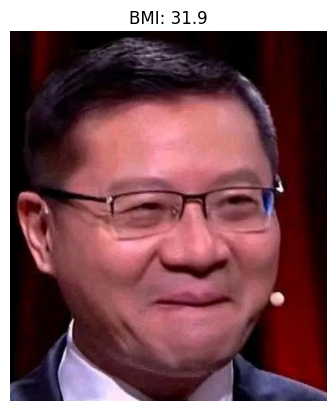

<ipython-input-13-7cbed6cba6c6>:352: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(single_test_gen)


array([[30.244904]], dtype=float32)

In [37]:
#single_test_img = '/home/jupyter/data/ml/BMI/Images/img_1001.bmp' #gcp
#single_test_img = path_gdrive + '/Data/Images/img_1001.bmp' #colab
single_test_img = path_gdrive + '/Data/Mannual_test/IMG_8955.JPG' #colab
#single_test_img = path_gdrive + '/Data/Images/img_1.bmp' #colab

#model.predict(single_test_img, show_img=True)
model.predict_external(single_test_img, show_img=True)

In [38]:
# model.predict(single_test_img, show_img=True)

It looks that `predict_external` works better because it crops face that provider a better preprocessed image input.

### Group Pictures Prediction Test

Face 1: Confidence - 0.9999997615814209
Face 1: Confidence - 0.9999994039535522
Face 1: Confidence - 0.999976396560669
Face 1: Confidence - 0.9999477863311768
Face 2: Confidence - 0.9912453293800354
Face 1: Confidence - 0.999819815158844
Face 1: Confidence - 0.999988317489624
Face 1: Confidence - 0.9999710321426392
Face 1: Confidence - 0.9999980926513672
Face 1: Confidence - 0.9999815225601196
Face 1: Confidence - 0.9997977614402771
Found 10 validated image filenames.


<ipython-input-13-7cbed6cba6c6>:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['processed_paths'], test_df['processed_names'] = processed_img_paths, processed_img_names
<ipython-input-13-7cbed6cba6c6>:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['processed_paths'], test_df['processed_names'] = processed_img_paths, processed_img_names
<ipython-input-13-7cbed6cba6c6>:379: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.p

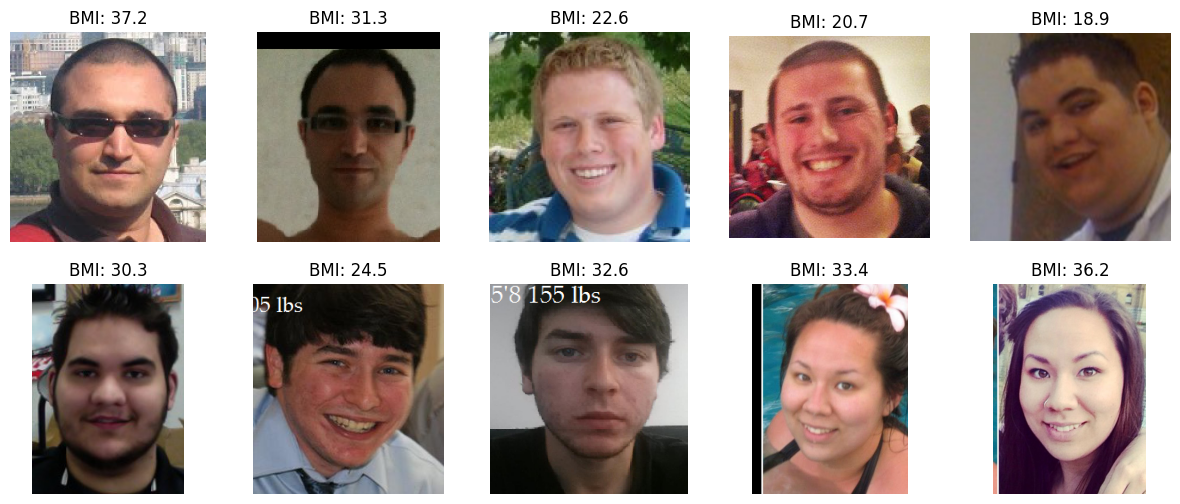

In [39]:
# Call the predict function
img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images'
show_img = True
# predictions = model.predict(img_dir, input_generator=extra_test_set_gen, 
#                              input_df=extra_images_df, show_img=show_img)

predictions = model.predict_external_dir(img_dir, 
                                     input_df=extra_images_df, show_img=show_img)

In [40]:
# predictions = model.predict(img_dir, input_generator=extra_test_set_gen, 
#                              input_df=extra_images_df, show_img=show_img)

In [41]:
# extra_images_df[['name', 'bmi', 'gender']]